# S3

In [1]:
import boto3
import zipfile
import os
import shutil

## Get From S3

### Normal

In [9]:
# S3 Setup
s3 = boto3.client("s3")
bucket_name = "ms-thesis-sagemaker"  # Replace with your S3 bucket
s3_file_path = "chunk_test_0.zip"  # Replace with the file name in S3
local_zip_path = "/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_test_hf_dataset/chunk_0.zip"  # Where to save in SageMaker

# Download the ZIP file from S3
s3.download_file(bucket_name, s3_file_path, local_zip_path)
print("ZIP file downloaded from S3 successfully!")

ZIP file downloaded from S3 successfully!


In [10]:
extract_path = "/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_test_hf_dataset/"  # Where to extract

# Unzip the file
with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP file extracted successfully!")

ZIP file extracted successfully!


In [11]:
os.remove(local_zip_path)
print("ZIP file deleted to free space.")

ZIP file deleted to free space.


### Embeddings

In [2]:
s3 = boto3.client("s3")
bucket_name = "ms-thesis-sagemaker"

In [3]:
for i in range(20):
    s3_file_path = f"embedded_mbert_bpe_train_hf_dataset/chunk_{i}.zip"
    local_zip_path = f"/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_train_hf_dataset/chunk_{i}.zip"

    s3.download_file(bucket_name, s3_file_path, local_zip_path)

    extract_path = "/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_train_hf_dataset/"
    
    with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    os.remove(local_zip_path)

In [12]:
for i in range(5):
    s3_file_path = f"embedded_mbert_bpe_test_hf_dataset/chunk_{i}.zip"
    local_zip_path = f"/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_test_hf_dataset/chunk_{i}.zip"

    s3.download_file(bucket_name, s3_file_path, local_zip_path)

    extract_path = "/home/ec2-user/SageMaker/ms-thesis/model-variants/data/embedded_mbert_bpe_test_hf_dataset/"
    
    with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    os.remove(local_zip_path)

## Move to S3

In [ ]:
# function to zip and upload
def zip_and_upload_to_s3(source_folder):
    bucket_name = "ms-thesis-sagemaker"

    zip_file = f"{source_folder}.zip"
    s3_key = f"uploads/{zip_file}"

    # Create a zip archive
    shutil.make_archive(zip_file.replace(".zip", ""), 'zip', source_folder)
    print(f"Zipped {source_folder} -> {zip_file}")

    # Upload to S3
    s3_client = boto3.client("s3")
    s3_client.upload_file(zip_file, bucket_name, s3_key)
    print(f"Uploaded to S3: s3://{bucket_name}/{s3_key}")

    # delete zip file
    os.remove(zip_file)
    print("ZIP file deleted to free space.")

    return f"s3://{bucket_name}/{s3_key}"

In [ ]:
# zip logs
zip_and_upload_to_s3("logs")

In [ ]:
# zip results
zip_and_upload_to_s3("model-variants/results")

In [ ]:
# zip results
zip_and_upload_to_s3("model-variants/models")

# Importing all the important libraries

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install transformers sentence_transformers sentencepiece peft datasets bert_score sacrebleu

In [ ]:
!conda update -n base -c conda-forge conda -y

In [ ]:
!conda install conda-forge::rouge-score -y

In [ ]:
!pip install bitsandbytes

In [1]:
import pandas as pd
import numpy as np
import torch
import sentencepiece as spm
from utils.dataframe import (
    load_gen_df, save_tmp_df, load_tmp_df, load_models_df,
    save_model_variants_df, load_model_variants_df,
    save_model_variants_hf, load_model_variants_hf,
    save_model_variants_gen_df, load_model_variants_gen_df,
    convert_to_hf, save_model_variants_chunk_hf,
)
from utils.gpu import get_device
from utils.common import (
    apply_lora, TRAIN_ARGS,
    generate_masked_predictions_hf_batch, generate_mt5_predictions_hf_batch,
    compute_metrics_hf_batch,
    convert_to_mean_scores_df,
    get_fine_tuned_model, get_embedded_fine_tuned_model,
    compute_multilingual_masked_perplexity_hf_batch, compute_mt5_perplexity_batch,
    extract_metrics_from_logs,
    plot_training_metrics, plot_evaluation_metrics
)
from IPython.display import display
from tqdm.notebook import tqdm
from transformers import (
    logging,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Trainer, TrainingArguments,
    EarlyStoppingCallback,
    BertForMaskedLM, RobertaForMaskedLM, AutoModelForMaskedLM
)
from peft import PeftModel
from torch import nn

2025-02-26 03:33:49.104719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 03:33:49.129286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 03:33:49.129321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 03:33:49.144416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 03:33:50.007134: W tensorflow/compiler/tf

# Set settings

In [2]:
tqdm.pandas()

In [3]:
# Suppress specific warnings from the transformers library
logging.set_verbosity_error()

# Common

In [4]:
# gpu device 
device = get_device()

2025-02-26 03:33:53.339832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Tensorflow GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using PyTorch device: cuda
GPU Name: NVIDIA A10G


2025-02-26 03:33:53.379337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-26 03:33:53.381795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
# spt models
spt_models = {
    "bpe": spm.SentencePieceProcessor("spt/spt_bpe.model"),
    "unigram": spm.SentencePieceProcessor("spt/spt_unigram.model"),
}

In [6]:
# model names
train_model_names = {
    "mBERT": "bert-base-multilingual-cased",
    "mT5": "google/mt5-small",
    "XLM-R": "xlm-roberta-base"
}

# Data Preprocessing
Datasets used for training:
- myXNLI & ALT Corpus (normalized)
- Back-translated datasets (NLLB, Seamless M4T)
- Pseudo Parallel Corpus (Minilm, LaBse)

In [ ]:
# Load and process dataset
def load_and_rename_columns_multilingual(file_name):
    df = load_gen_df(f"{file_name}")

    column_mapping = {
        "english": "source",
        "burmese": "target",
        "english_back_translated": "source",
        "burmese_translated": "target",
    }
    
    df = df.rename(columns=column_mapping)
    
    # Ensure only required columns exist
    df = df[["source", "target"]]

    return df

In [ ]:
# datasets
datasets = {
    "normal": [
        "myxnli_normalized_1", 
        "myxnli_normalized_2", 
        "alt_combined_normalized"
    ],
    "nllb_back_translated": [
        "myxnli_nllb_back_translated_final_1", 
        "myxnli_nllb_back_translated_final_2", 
        "alt_combined_nllb_back_translated_final"
    ],
    "seamless_m4t_back_translated": [
        "myxnli_seamless_m4t_back_translated_final_1", 
        "myxnli_seamless_m4t_back_translated_final_2", 
        "alt_combined_seamless_m4t_back_translated_final"
    ],
    "minilm_pseudo_parallel_corpus": [
        "minilm_pseudo_parallel_corpus_final"
    ],
    "labse_pseudo_parallel_corpus": [
        "labse_pseudo_parallel_corpus_final"
    ],
}

In [ ]:
# Load and process datasets
loaded_datasets = {}
for key, file_list in datasets.items():
    loaded_datasets[key] = [load_and_rename_columns_multilingual(file) for file in file_list]

In [ ]:
# combine all datasets
combined = pd.concat(
    loaded_datasets["normal"] + 
    loaded_datasets["nllb_back_translated"] + 
    loaded_datasets["seamless_m4t_back_translated"],
    ignore_index=True
)

In [ ]:
# Shuffle the data to prevent order bias
combined = combined.sample(frac=1).reset_index(drop=True)

In [ ]:
# display combined dataset
display(combined.head())

,source,target
0,disheartened in hong kong,ဟောင်ကောင်မှာ စိတ်ပျက်သွားတယ်။
1,kyushu is an important part of japanese mythol...,Kyushu ဟာ ဂျပန် ဒဏ္ဍာရီရဲ့ အရေးပါတဲ့ အစိတ်အပို...
2,it's simple for sure.,ဒါက ရိုးရှင်းတဲ့အတွက် အသေအချာပါ။
3,and they think that i'm better than i am.,ပြီးတော့ သူတို့က ငါထက် ပိုကောင်းတယ်လို့ ထင်နေက...
4,"there were jokes about these comments, even th...",ဒီမှတ်ချက်တွေအကြောင်း နောက်ပြောင်တာတွေ ရှိခဲ့တ...


In [ ]:
# print length
print(f"Combined dataset length: {len(combined)}")

Combined dataset length: 1627576


In [ ]:
# save data
save_model_variants_df(combined, "combined")

In [ ]:
# combine all datasets including pesudo parallel
combined_pseudo_parallel_corpus = pd.concat(
    loaded_datasets["normal"] + 
    loaded_datasets["nllb_back_translated"] + 
    loaded_datasets["seamless_m4t_back_translated"] +
    loaded_datasets["minilm_pseudo_parallel_corpus"] +
    loaded_datasets["labse_pseudo_parallel_corpus"],
    ignore_index=True
)

In [ ]:
# Shuffle the data to prevent order bias
combined_pseudo_parallel_corpus = combined_pseudo_parallel_corpus.sample(frac=1).reset_index(drop=True)

In [ ]:
# display combined dataset
display(combined_pseudo_parallel_corpus.head())

,source,target
0,i know you've never done it.,မင်းမလုပ်ဘူးဆိုတာ ငါသိတယ်။
1,people who shop at tiffany's are generally ver...,Tiffany's မှာ ဈေးဝယ်သူတွေဟာ အများအားဖြင့် အလွန...
2,daniel told his colleagues that they are to bl...,ဟောလိဝုဒ်၏ လက်ရှိအခြေအနေအတွက် ၎င်းတို့ကို အပြစ...
3,julia sweeney's little sister is dead.,Julia Sweeney ရဲ့ ညီမလေး က သေဆုံးသွားတယ်
4,she doesn't call this mission ambitious.,သူမဟာ ဒီတာဝန်ကို ရည်မှန်းချက်ကြီးတယ်လို့ မခေါ်...


In [ ]:
# display data size
print(f"Total Size: {len(combined_pseudo_parallel_corpus)}")

Total Size: 3001668


In [ ]:
# save data
save_model_variants_df(combined_pseudo_parallel_corpus, "combined_pseudo_parallel_corpus")

# 1. Fine-Tuning Transformer Models for Burmese
This notebook fine-tunes three transformer models:
- mBERT (best perplexity, but weak BLEU/ROUGE)
- mT5 (best for generation, but requires more data)
- XLM-R (good BLEU/ROUGE, but poor perplexity)

Apply:
- Sentence-Piece Tokenization for Burmese segmentation
- LoRA for efficient fine-tuning
- Prefix-Tuning for lightweight adaptations
- Mixed Precision Training for speed improvements

In [8]:
# train tokenizers
train_tokenizers = {
    "mBERT": AutoTokenizer.from_pretrained(train_model_names["mBERT"]),
    "mT5": AutoTokenizer.from_pretrained(train_model_names["mT5"], use_fast=False, legacy=True),
    "XLM-R": AutoTokenizer.from_pretrained(train_model_names["XLM-R"])
}

In [9]:
# train models
train_models = {
    "mBERT": AutoModelForMaskedLM.from_pretrained(train_model_names["mBERT"]).to(device),
    "mT5": AutoModelForSeq2SeqLM.from_pretrained(train_model_names["mT5"]).to(device),
    "XLM-R": AutoModelForMaskedLM.from_pretrained(train_model_names["XLM-R"]).to(device)
}

## Tokenize

In [ ]:
def tokenize(examples, tokenizer, spt_tokenizer, model_name):
    """
    Tokenizes Burmese text using the selected SentencePiece model before applying Transformer tokenization.
    """
    # Apply SentencePiece Tokenization
    batch_source_tokens = [spt_tokenizer.encode(text, out_type=str) for text in examples["source"]]
    batch_target_tokens = [spt_tokenizer.encode(text, out_type=str) for text in examples["target"]]

    # Flatten and convert tokens to text
    batch_source_texts = [" ".join(tokens) for tokens in batch_source_tokens]
    batch_target_texts = [" ".join(tokens) for tokens in batch_target_tokens]

    if "t5" in model_name.lower():
        # Tokenize using mT5 tokenizer (Seq2Seq)
        model_inputs = tokenizer(
            batch_source_texts, 
            padding="max_length", 
            truncation=True, 
            max_length=512
        )
        
        # Tokenize target (labels) separately (mT5 requires explicit target tokenization)
        labels = tokenizer(
            batch_target_texts, 
            padding="max_length", 
            truncation=True, 
            max_length=512
        )["input_ids"]
        
        # Replace pad tokens in labels with -100 (Hugging Face ignores -100 in loss calculation)
        labels = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels]

        model_inputs["labels"] = labels  # Assign labels for training

        return model_inputs
    
    else:
        # Tokenize using tokenizer
        model_inputs = tokenizer(
            batch_source_texts, 
            padding="max_length", 
            truncation=True, 
            max_length=512
        )
        labels = tokenizer(
            batch_target_texts, 
            padding="max_length", 
            truncation=True, 
            max_length=512
        )["input_ids"]

        model_inputs["labels"] = labels  # Assign labels for MLM-style training

        return model_inputs

In [ ]:
# tokenize for each model and spt
for model_name, tokenizer in train_tokenizers.items():
    for spt_name, spt_tokenizer in spt_models.items():
        # load dataset
        if "t5" in model_name.lower():
            dataset = load_model_variants_df("combined_pseudo_parallel_corpus")
        else:
            dataset = load_model_variants_df("combined")

        # Split into 80% train, 20% test
        train_df = dataset.sample(frac=0.8, random_state=42)
        test_df = dataset.drop(train_df.index)

        # Convert to Hugging Face Dataset
        train_df = convert_to_hf(train_df)
        test_df = convert_to_hf(test_df)

        # apply tokenization to train dataset
        train_tokenized = train_df.map(
            lambda x, _: tokenize(x, tokenizer, spt_tokenizer, model_name),
            batched=True,
            batch_size=16,
            desc=f"Tokenizing train dataset for {model_name} with {spt_name}",
            with_indices=True,  # Passing index as a second argument
            num_proc=10
        )

        # memory occur when mT5 with unigram
        if "t5" in model_name.lower():
            chunk_size = 5
        else:
            chunk_size = 1

        # save
        save_model_variants_hf(train_tokenized, f"{model_name.lower()}_{spt_name}_train", chunk_size)

        # apply tokenization to train dataset
        test_tokenized = test_df.map(
            lambda x, _: tokenize(x, tokenizer, spt_tokenizer, model_name),
            batched=True,
            batch_size=16,
            desc=f"Tokenizing test dataset for {model_name} with {spt_name}",
            with_indices=True,  # Passing index as a second argument
            num_proc=10
        )

        # save
        save_model_variants_hf(test_tokenized, f"{model_name.lower()}_{spt_name}_test", 1)


## Fine-Tuning

In [ ]:
# tokenized train dataset
tokenized_train_datasets = {
    model_name: {
        spt_name: load_model_variants_hf(f"{model_name.lower()}_{spt_name}_train")
        for spt_name in spt_models.keys()
    }
    for model_name in train_tokenizers.keys()
}

In [ ]:
# tokenized test dataset
tokenized_test_datasets = {
    model_name: {
        spt_name: load_model_variants_hf(f"{model_name.lower()}_{spt_name}_test")
        for spt_name in spt_models.keys()
    }
    for model_name in train_tokenizers.keys()
}

In [ ]:
def fine_tune_model(model_name, spt_name, batch_size):
    """
    Fine-tunes the model with LoRA on the specified SentencePiece tokenization (SPT).
    """
    print(f"Fine-tuning {model_name} using SPT-{spt_name.upper()}...")

    # Load tokenizer & model
    tokenizer = train_tokenizers[model_name]
    model = train_models[model_name]

    # Move model to GPU before applying LoRA
    model.to(device)

    # Apply LoRA for efficient parameter tuning
    model = apply_lora(model, model_name, device)

    # display trainable parameters
    print(model.print_trainable_parameters())
    
    # load dataset
    train_data = tokenized_train_datasets[model_name][spt_name]
    val_data = tokenized_test_datasets[model_name][spt_name]

    # for debug, remove comment
    #train_data = train_data.select(range(100))
    #val_data = val_data.select(range(100))

    trained_model_name = f"{model_name}_{spt_name.upper()}"

    # Define training arguments
    training_args = TrainingArguments(
        **TRAIN_ARGS,
        output_dir=f"model-variants/results/{trained_model_name}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        learning_rate=5e-5,
        logging_dir=f"model-variants/logs/{trained_model_name}",
        label_names=["labels"],
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Save trained model and tokenizer
    save_path = f"model-variants/models/{trained_model_name}"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Model `{model_name}` fine-tuned and saved at `{save_path}`.")

### mBert

#### BPE

In [ ]:
# fine tune with SPT-BPE
fine_tune_model("mBERT", "bpe", 16)

#### Unigram

In [ ]:
# fine tune with SPT-Unigram
fine_tune_model("mBERT", "unigram", 16)

### XLM-R

#### BPE

In [ ]:
# fine tune with SPT-BPE
fine_tune_model("XLM-R", "bpe", 8)

#### Unigram

In [ ]:
# fine tune with SPT-Unigram
fine_tune_model("XLM-R", "unigram", 8)

### mT5

#### BPE

In [ ]:
# fine tune with SPT-BPE
fine_tune_model("mT5", "bpe", 8)

#### Unigram

In [ ]:
# fine tune with SPT-Unigram
fine_tune_model("mT5", "unigram", 8)

## Train Results

### mBert

#### BPE

In [13]:
# load train results
mbert_bpe_fined_tuned_train_results, mbert_bpe_fined_tuned_eval_results, mbert_bpe_fine_tuned_final_results = extract_metrics_from_logs("mBERT_BPE")

Latest TensorFlow Event File: model-variants/logs/mBERT_BPE/events.out.tfevents.1739759904.ip-172-16-36-102.ap-northeast-1.compute.internal.536.0


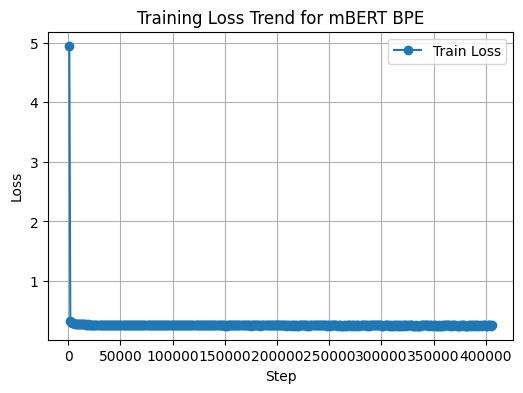

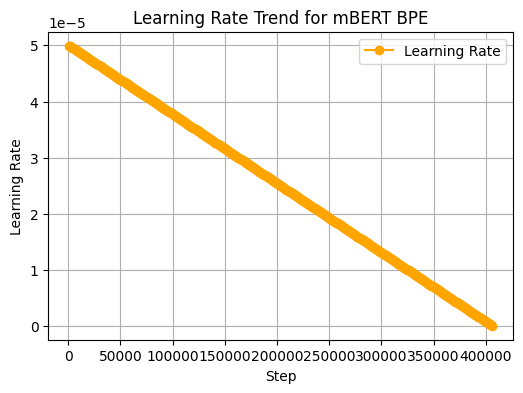

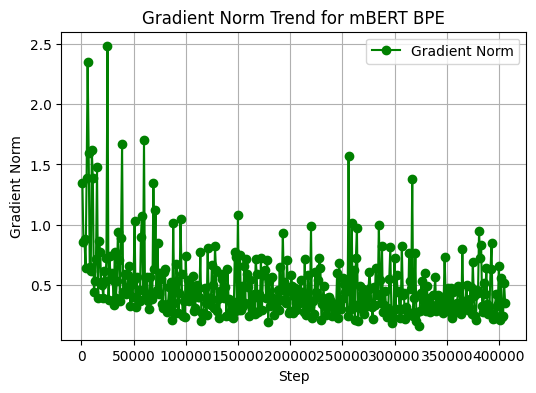

In [14]:
# plot train results
plot_training_metrics(mbert_bpe_fined_tuned_train_results, "mBERT BPE")

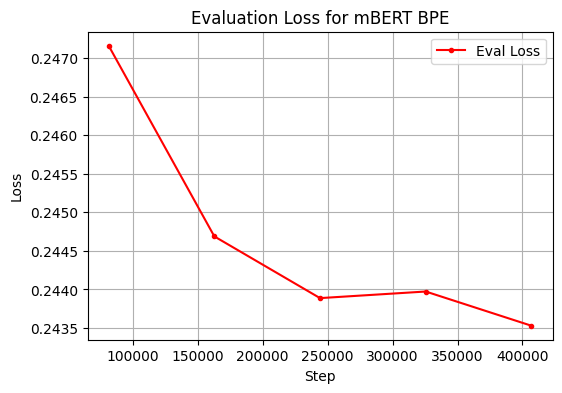

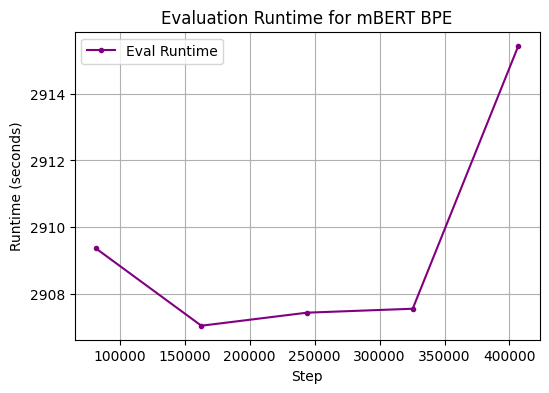

In [15]:
# plot eval results
plot_evaluation_metrics(mbert_bpe_fined_tuned_eval_results, "mBERT BPE")

In [16]:
# display final result
display(mbert_bpe_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
410,406895,1.721222e+18,0.267992,138926.546875,46.861,2.929


In [17]:
# save train results
save_model_variants_gen_df(mbert_bpe_fined_tuned_train_results, "mbert_bpe_fined_tuned_train_results")
save_model_variants_gen_df(mbert_bpe_fined_tuned_eval_results, "mbert_bpe_fined_tuned_eval_results")
save_model_variants_gen_df(mbert_bpe_fine_tuned_final_results, "mbert_bpe_fine_tuned_final_results")

#### Unigram

In [9]:
# load train results
mbert_unigram_fined_tuned_train_results, mbert_unigram_fined_tuned_eval_results, mbert_unigram_fine_tuned_final_results = extract_metrics_from_logs("mBERT_UNIGRAM")

Latest TensorFlow Event File: model-variants/logs/mBERT_UNIGRAM/events.out.tfevents.1739799160.ip-172-16-32-247.ap-northeast-1.compute.internal.4547.0


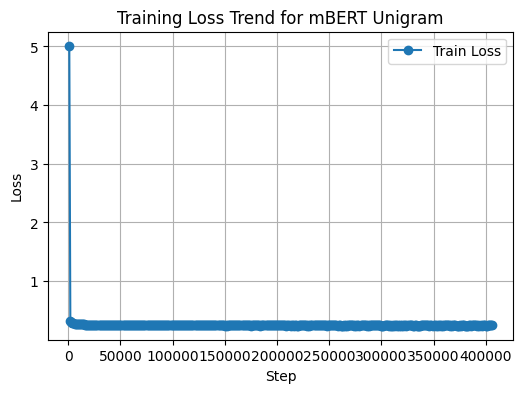

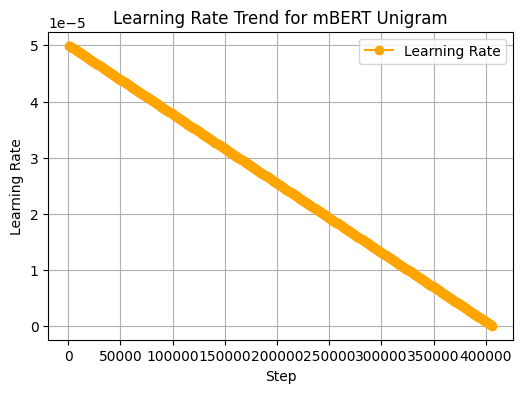

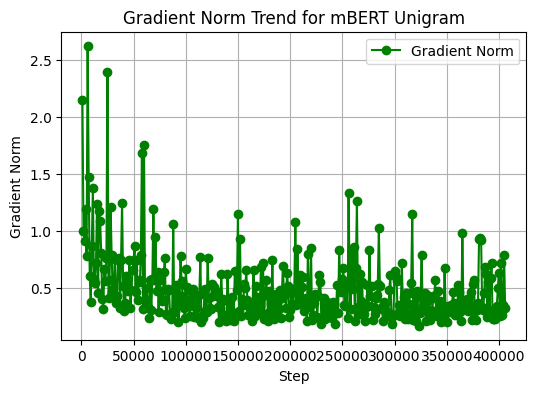

In [10]:
# plot train results
plot_training_metrics(mbert_unigram_fined_tuned_train_results, "mBERT Unigram")

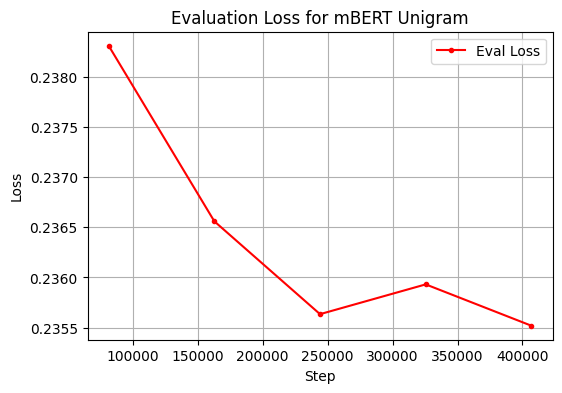

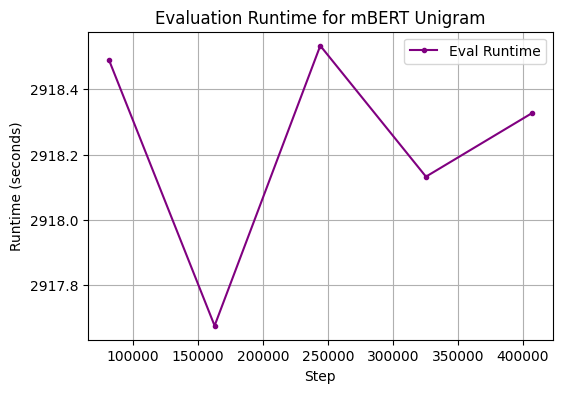

In [11]:
# plot eval results
plot_evaluation_metrics(mbert_unigram_fined_tuned_eval_results, "mBERT Unigram")

In [12]:
# display final result
display(mbert_unigram_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
410,406895,1.721222e+18,0.259764,139356.4375,46.716999,2.92


In [22]:
# save train results
save_model_variants_gen_df(mbert_unigram_fined_tuned_train_results, "mbert_unigram_fined_tuned_train_results")
save_model_variants_gen_df(mbert_unigram_fined_tuned_eval_results, "mbert_unigram_fined_tuned_eval_results")
save_model_variants_gen_df(mbert_unigram_fine_tuned_final_results, "mbert_unigram_fine_tuned_final_results")

### XLM-R

#### BPE

In [23]:
# load train results
xlmr_bpe_fined_tuned_train_results, xlmr_bpe_fined_tuned_eval_results, xlmr_bpe_fine_tuned_final_results = extract_metrics_from_logs("XLM-R_BPE")

Latest TensorFlow Event File: model-variants/logs/XLM-R_BPE/events.out.tfevents.1739688674.ip-172-16-60-40.ap-northeast-1.compute.internal.16323.0


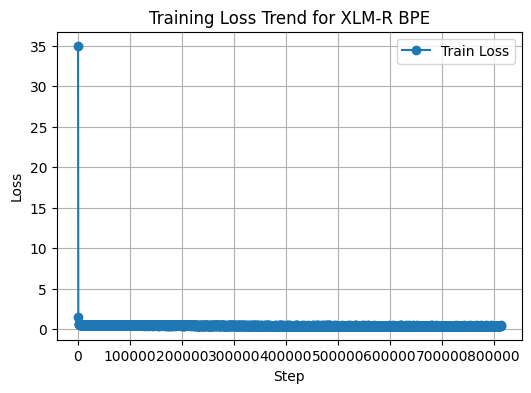

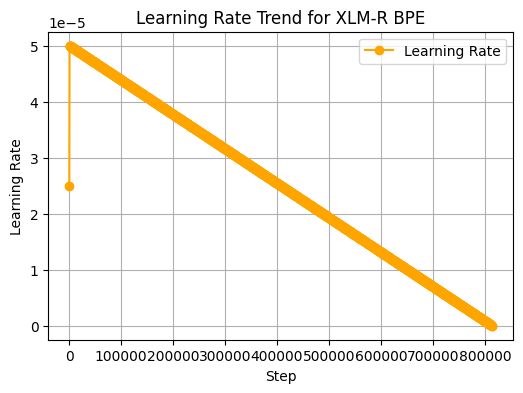

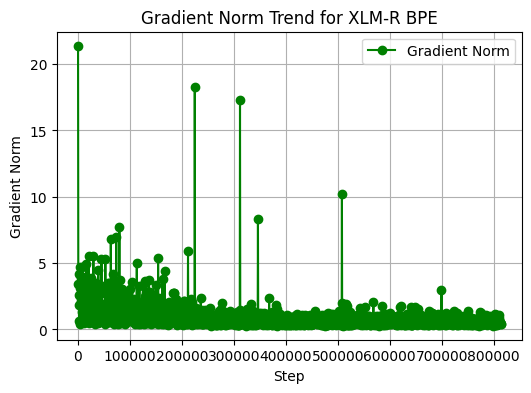

In [24]:
# plot train results
plot_training_metrics(xlmr_bpe_fined_tuned_train_results, "XLM-R BPE")

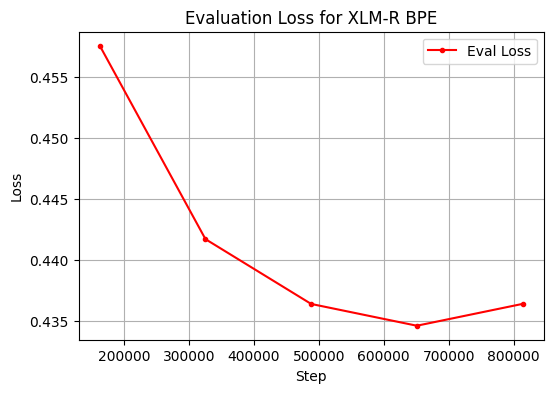

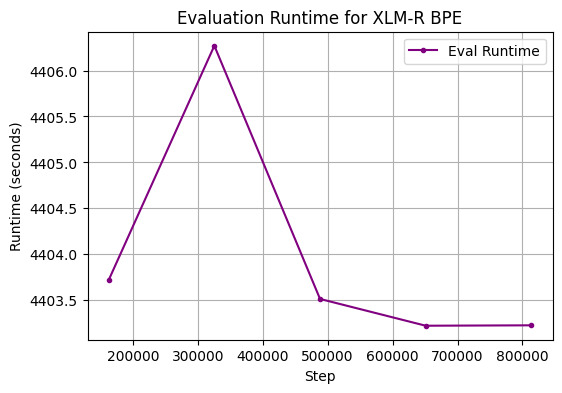

In [25]:
# plot eval results
plot_evaluation_metrics(xlmr_bpe_fined_tuned_eval_results, "XLM-R BPE")

In [26]:
# display final result
display(xlmr_bpe_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
1631,813790,1.723831e+18,0.469883,206181.078125,31.576,3.947


In [ ]:
# save train results
save_model_variants_gen_df(xlmr_bpe_fined_tuned_train_results, "xlm-r_bpe_fined_tuned_train_results")
save_model_variants_gen_df(xlmr_bpe_fined_tuned_eval_results, "xlm-r_bpe_fined_tuned_eval_results")
save_model_variants_gen_df(xlmr_bpe_fine_tuned_final_results, "xlm-r_bpe_fine_tuned_final_results")

#### Unigram

In [28]:
# load train results
xlmr_unigram_fined_tuned_train_results, xlmr_unigram_fined_tuned_eval_results, xlmr_unigram_fine_tuned_final_results = extract_metrics_from_logs("XLM-R_UNIGRAM")

Latest TensorFlow Event File: model-variants/logs/XLM-R_UNIGRAM/events.out.tfevents.1739771865.ip-172-16-60-83.ap-northeast-1.compute.internal.16751.0


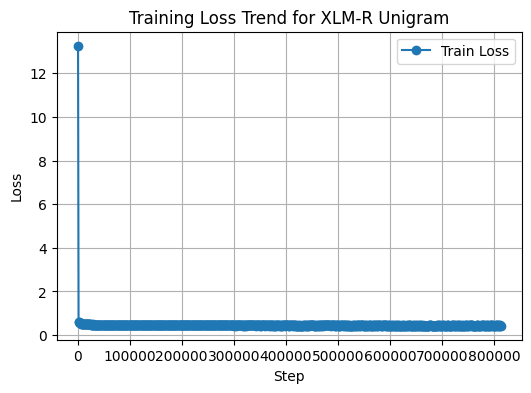

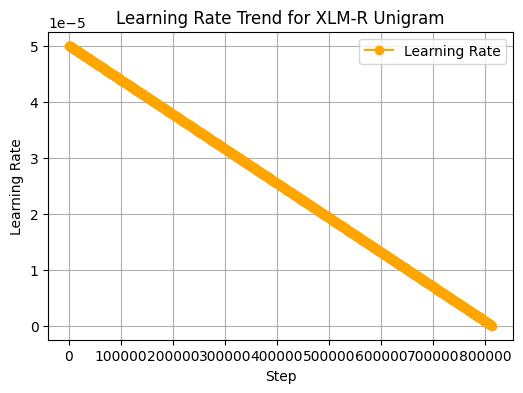

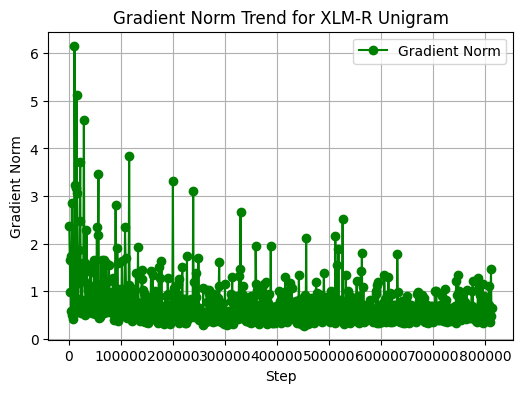

In [29]:
# plot train results
plot_training_metrics(xlmr_unigram_fined_tuned_train_results, "XLM-R Unigram")

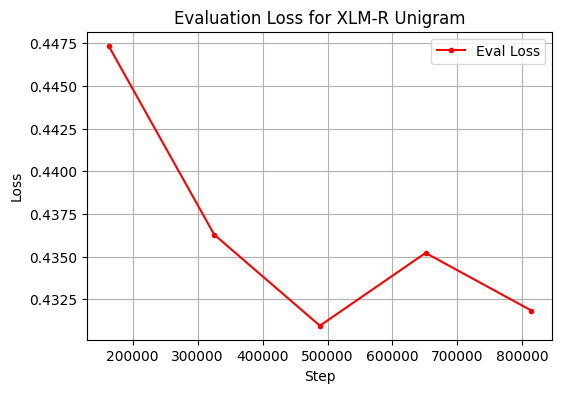

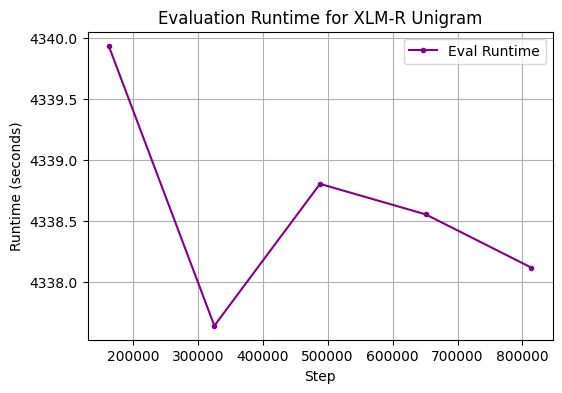

In [30]:
# plot eval results
plot_evaluation_metrics(xlmr_unigram_fined_tuned_eval_results, "XLM-R Unigram")

In [31]:
# display final result
display(xlmr_unigram_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
817,813790,1.723831e+18,0.459188,204650.546875,31.812,3.976


In [ ]:
# save train results
save_model_variants_gen_df(xlmr_unigram_fined_tuned_train_results, "xlm-r_unigram_fined_tuned_train_results")
save_model_variants_gen_df(xlmr_unigram_fined_tuned_eval_results, "xlm-r_unigram_fined_tuned_eval_results")
save_model_variants_gen_df(xlmr_unigram_fine_tuned_final_results, "xlm-r_unigram_fine_tuned_final_results")

### mT5

#### BPE

In [8]:
# load train results
mt5_bpe_fined_tuned_train_results, mt5_bpe_fined_tuned_eval_results, mt5_bpe_fine_tuned_final_results = extract_metrics_from_logs("mT5_BPE")

Latest TensorFlow Event File: model-variants/logs/mT5_BPE/events.out.tfevents.1739770482.ip-172-16-50-187.ap-northeast-1.compute.internal.7990.0


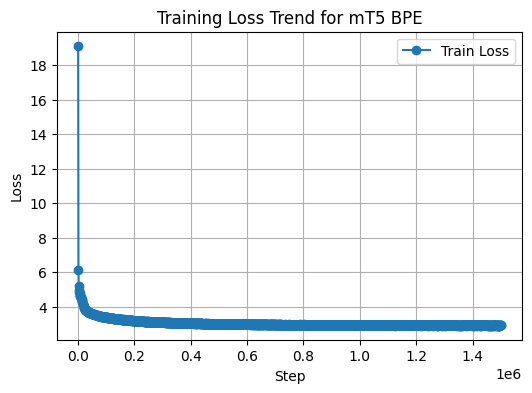

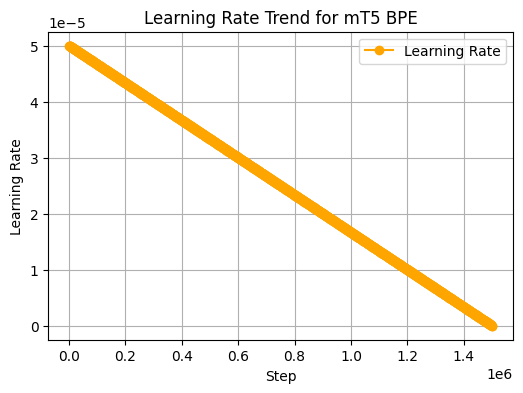

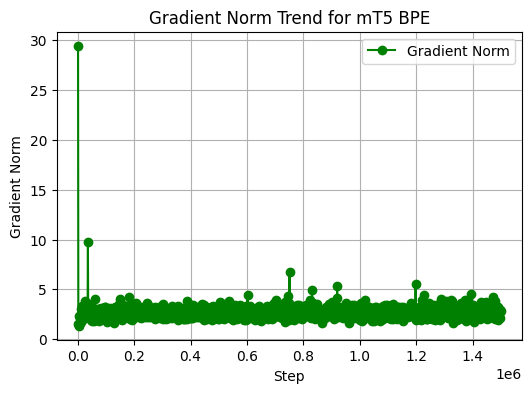

In [9]:
# plot train results
plot_training_metrics(mt5_bpe_fined_tuned_train_results, "mT5 BPE")

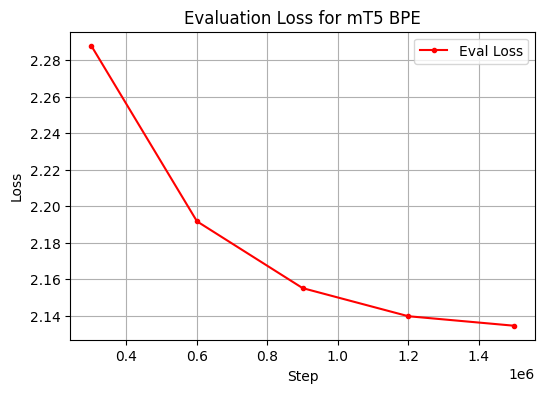

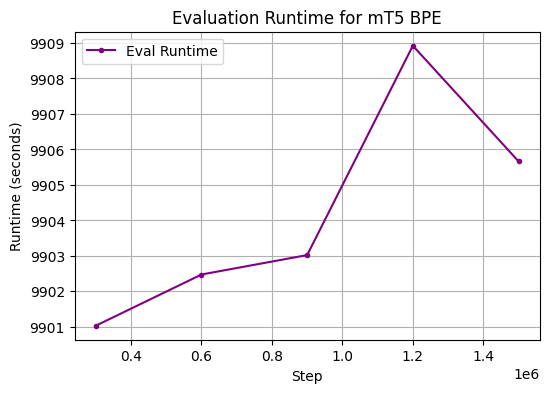

In [10]:
# plot eval results
plot_evaluation_metrics(mt5_bpe_fined_tuned_eval_results, "mT5 BPE")

In [11]:
# display final result
display(mt5_bpe_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
1504,1500835,6.361214e+18,3.052518,509079.28125,23.584999,2.948


In [12]:
# save train results
save_model_variants_gen_df(mt5_bpe_fined_tuned_train_results, "mt5_bpe_fined_tuned_train_results")
save_model_variants_gen_df(mt5_bpe_fined_tuned_eval_results, "mt5_bpe_fined_tuned_eval_results")
save_model_variants_gen_df(mt5_bpe_fine_tuned_final_results, "mt5_bpe_fine_tuned_final_results")

#### Unigram

In [13]:
# load train results
mT5_unigram_fined_tuned_train_results, mT5_unigram_fined_tuned_eval_results, mT5_unigram_fine_tuned_final_results = extract_metrics_from_logs("mT5_UNIGRAM")

Latest TensorFlow Event File: model-variants/logs/mT5_UNIGRAM/events.out.tfevents.1739931406.ip-172-16-49-88.ap-northeast-1.compute.internal.27707.1


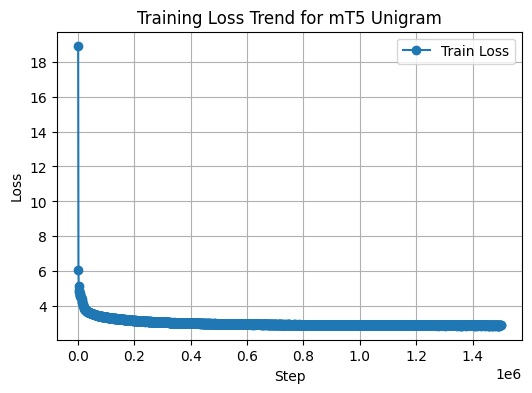

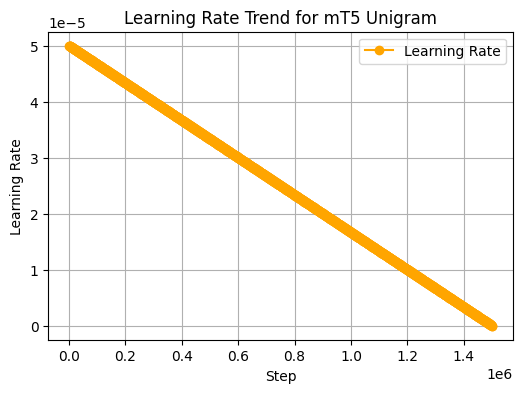

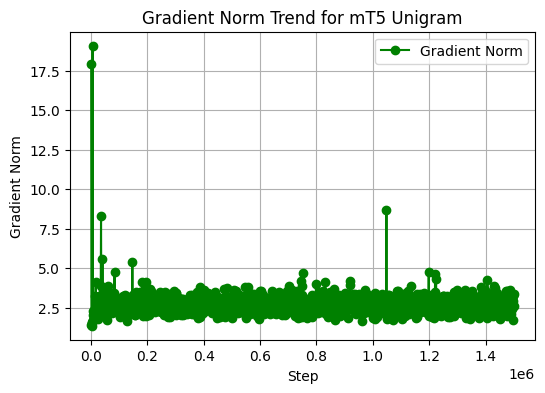

In [14]:
# plot train results
plot_training_metrics(mT5_unigram_fined_tuned_train_results, "mT5 Unigram")

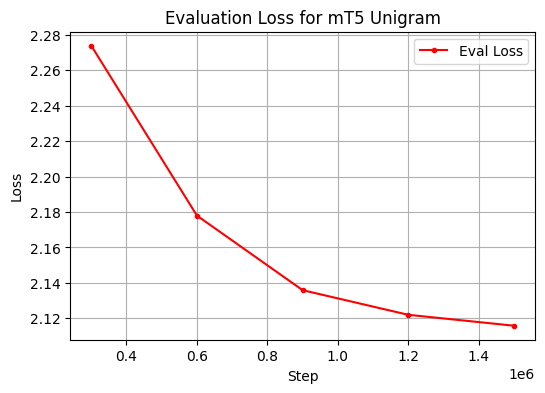

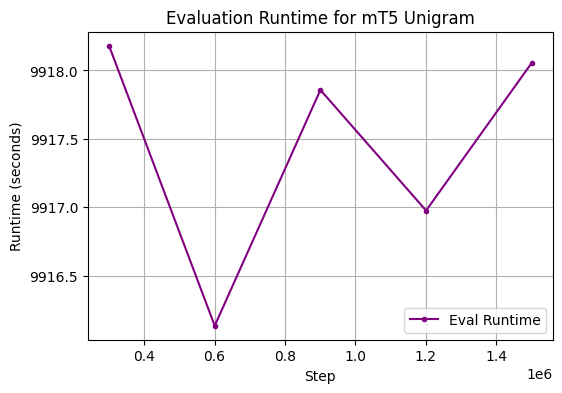

In [15]:
# plot eval results
plot_evaluation_metrics(mT5_unigram_fined_tuned_eval_results, "mT5 Unigram")

In [16]:
# display final result
display(mT5_unigram_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
1504,1500835,6.361214e+18,3.037897,508430.40625,23.615,2.952


In [17]:
# save train results
save_model_variants_gen_df(mT5_unigram_fined_tuned_train_results, "mT5_unigram_fined_tuned_train_results")
save_model_variants_gen_df(mT5_unigram_fined_tuned_eval_results, "mT5_unigram_fined_tuned_eval_results")
save_model_variants_gen_df(mT5_unigram_fine_tuned_final_results, "mT5_unigram_fine_tuned_final_results")

## Generate Predictions

In [ ]:
# Function to generate predictions for fine-tuned model using Hugging Face Dataset
def generate_predictions_fine_tuned_model(model_name, spt_name):
    base_model_name = train_model_names[model_name]

    # Load tokenizers & models
    model, tokenizer = get_fine_tuned_model(model_name, spt_name, base_model_name, device)
    model.eval()

    # Load dataset 
    dataset = load_models_df("multilingual_combined")

    dataset = convert_to_hf(dataset)

    print(len(dataset))

    # remove comment for debug
    # dataset = dataset.select(range(100))

    # Run text generation
    if "mt5" in model_name.lower():
        dataset = generate_mt5_predictions_hf_batch(dataset, model, tokenizer, device)
    else:
        dataset = generate_masked_predictions_hf_batch(dataset, model, tokenizer, device)

    # Display results
    display(dataset.to_pandas().head())

    # Save dataset
    save_model_variants_gen_df(dataset, f"{model_name.lower()}_{spt_name}_trained_predictions")

### mBERT

In [ ]:
# generate predictions for mbert with BPE
generate_predictions_fine_tuned_model("mBERT", "bpe")

In [ ]:
# generate predictions for mbert with Unigram
generate_predictions_fine_tuned_model("mBERT", "unigram")

### XLM-R

In [ ]:
# generate predictions for XLM-R with BPE
generate_predictions_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# generate predictions for XLM-R with Unigram
generate_predictions_fine_tuned_model("XLM-R", "unigram")

### mT5

In [ ]:
# generate predictions for mT5 with BPE
generate_predictions_fine_tuned_model("mT5", "bpe")

In [ ]:
# generate predictions for mT5 with Unigram
generate_predictions_fine_tuned_model("mT5", "unigram")

## Evaluate Model Performance
Compute BLEU, ROUGE-1, ROUGE-2, ROUGE-3, ROUGE-L, chrF-S, BERTScore and Perplexity scores.

### Metrics

In [ ]:
# Function to Compute Metrics for Fine-Tuned Model using HF Dataset
def compute_metric_fine_tuned_model(model_name, spt_name):
    # Load dataset
    metrics_dataset = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_trained_predictions")
    metrics_dataset = convert_to_hf(metrics_dataset)

    # if debug, remove comment
    #metrics_dataset = metrics_dataset.select(range(100))  # Keep this for debugging

    # Compute metrics
    print(f"Processing Data for {model_name} with {spt_name.upper()}...")
    metrics_dataset = compute_metrics_hf_batch(metrics_dataset, device)

    # Display results
    print(f"Metrics scores for {model_name} with {spt_name.upper()}:")
    print(f"BLEU Score: {np.mean(metrics_dataset['bleu'])}")
    print(f"ROUGE-1 Score: {np.mean(metrics_dataset['rouge-1'])}")
    print(f"ROUGE-2 Score: {np.mean(metrics_dataset['rouge-2'])}")
    print(f"ROUGE-L Score: {np.mean(metrics_dataset['rouge-l'])}")
    print(f"chrF-S Score: {np.mean(metrics_dataset['chrf-s'])}")
    print(f"BERT Score: {np.mean(metrics_dataset['bert_score'])}")

    # Save results
    save_tmp_df(metrics_dataset, f"{model_name.lower()}_{spt_name}_trained_metrics")

#### mBERT

In [ ]:
# compute metric for fine tuned mBERT with BPE
compute_metric_fine_tuned_model("mBERT", "bpe")

In [ ]:
# compute metric for fine tuned mBERT with Unigram
compute_metric_fine_tuned_model("mBERT", "unigram")

#### XLM-R

In [ ]:
# compute metric for fine tuned XLM-R with BPE
compute_metric_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# compute metric for fine tuned XLM-R with Unigram
compute_metric_fine_tuned_model("XLM-R", "unigram")

#### mT5

In [ ]:
# compute metric for fine tuned mT5 with BPE
compute_metric_fine_tuned_model("mT5", "bpe")

In [ ]:
# compute metric for fine tuned mT5 with Unigram
compute_metric_fine_tuned_model("mT5", "unigram")

### Perplexity

In [ ]:
def compute_perplexity_fine_tuned_model(model_name, spt_name, batch_size=16):
    """
    Computes perplexity for a fine-tuned model using Hugging Face Dataset in batches.
    """
    base_model_name = train_model_names[model_name]

    print(f"Loading dataset for {model_name} with {spt_name}...")
    perplexity_dataset = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_trained_predictions")

    perplexity_dataset = convert_to_hf(perplexity_dataset)

    # for debug, remove comment
    # perplexity_dataset = perplexity_dataset.select(range(100))

    # Load Model & Tokenizer
    model, tokenizer = get_fine_tuned_model(model_name, spt_name, base_model_name, device)
    model.eval()

    print(f"Computing perplexity in batches of {batch_size}...")
    
    def compute_perplexity_batch(batch):
        texts = batch["generated"]  # Get text batch
        
        # Ensure all elements are strings and remove None values
        texts = [str(text) if text is not None else "" for text in texts]

        if "t5" in model_name.lower():
            perplexity_scores = compute_mt5_perplexity_batch(texts, model, tokenizer, device)
        else:
            perplexity_scores = compute_multilingual_masked_perplexity_hf_batch(texts, model, tokenizer, device)

        return {"perplexity": perplexity_scores}

    # Compute perplexity in batches
    perplexity_dataset = perplexity_dataset.map(compute_perplexity_batch, batched=True, batch_size=batch_size)

    # Display Results
    mean_perplexity = np.mean(perplexity_dataset["perplexity"])
    print(f"Perplexity Score: {mean_perplexity:.4f}")

    # Save dataset
    save_tmp_df(perplexity_dataset, f"{model_name.lower()}_{spt_name}_trained_perplexity")

#### mBERT

In [ ]:
# compute perplexity with BPE
compute_perplexity_fine_tuned_model("mBERT", "bpe")

In [ ]:
# compute perplexity with Unigram
compute_perplexity_fine_tuned_model("mBERT", "unigram")

#### XLM-R

In [ ]:
# compute perplexity with BPE
compute_perplexity_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# compute perplexity with Unigram
compute_perplexity_fine_tuned_model("XLM-R", "unigram")

#### mt5

In [ ]:
# compute perplexity with BPE
compute_perplexity_fine_tuned_model("mT5", "bpe")

In [ ]:
# compute perplexity with Unigram
compute_perplexity_fine_tuned_model("mT5", "unigram")

### Save Evaluation Results

In [9]:
# combine evaluation results
for model_name in train_model_names.keys():
    for spt_name in spt_models.keys():
        print(f"Processing {model_name} with {spt_name}...")

        evaluation_results = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_trained_predictions")

        # load metrics and set
        metrics = load_tmp_df(f"{model_name}_{spt_name}_trained_metrics")
        evaluation_results["bleu"] = metrics["bleu"]
        evaluation_results["rouge-1"] = metrics["rouge-1"]
        evaluation_results["rouge-2"] = metrics["rouge-2"]
        evaluation_results["rouge-l"] = metrics["rouge-l"]
        evaluation_results["chrf-s"] = metrics["chrf-s"]
        evaluation_results["bert_score"] = metrics["bert_score"]

        # load perplexity and set
        perplexity = load_tmp_df(f"{model_name}_{spt_name}_trained_perplexity")
        evaluation_results["perplexity"] = perplexity["perplexity"]

        save_model_variants_gen_df(evaluation_results, f"{model_name.lower()}_{spt_name}_trained_evaluation_results")

Processing mBERT with bpe...
Processing mBERT with unigram...
Processing mT5 with bpe...
Processing mT5 with unigram...
Processing XLM-R with bpe...
Processing XLM-R with unigram...


## Benchmarking and Analysis

In [10]:
# load data
trained_benchmarking_datasets = {}
for model_name in train_model_names.keys():
    for spt_name in spt_models.keys():
        df = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_trained_evaluation_results")
        trained_benchmarking_datasets[f"{model_name} {spt_name.upper()}"] = df

In [11]:
# convert to mean score df
trained_benchmarking_mean_scores = convert_to_mean_scores_df(trained_benchmarking_datasets)

In [12]:
# Display mean scores
display(trained_benchmarking_mean_scores)

,name,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,chrF-S,BERT Score,Perplexity
mBERT BPE,mBERT BPE,0.412640,0.308111,0.160576,0.308111,99.932008,0.999906,2.264543e+01
mBERT UNIGRAM,mBERT UNIGRAM,0.412640,0.308111,0.160576,0.308111,99.932008,0.999906,3.952771e+01
mT5 BPE,mT5 BPE,0.038441,0.179186,0.076829,0.179155,31.073819,0.773639,8.696416e+03
mT5 UNIGRAM,mT5 UNIGRAM,0.037098,0.177381,0.077179,0.177349,32.306038,0.775723,8.071516e+03
XLM-R BPE,XLM-R BPE,0.876002,0.308115,0.160583,0.308115,99.972363,0.999956,3.164637e+11
XLM-R UNIGRAM,XLM-R UNIGRAM,0.876002,0.308115,0.160583,0.308115,99.972363,0.999956,5.839325e+11


In [13]:
# save benchmarking results
save_model_variants_gen_df(trained_benchmarking_mean_scores, "trained_evaluation_results")

# 2. Enhance Burmese Contextual Representations
- Use LASER, mUSE, and FastText for cross-lingual and morphology-aware training.
- Fine-tune mBERT, XLM-R on Burmese dataset after adding contextual embedded.
- Train models again using combined embedded.

In [7]:
# embedding model names
embedding_model_names = ["mBERT", "XLM-R"]

## Embedding

Moved to embeddings-dataset-preparation.ipynb

## Convert To GPU

In [ ]:
# function to convert to gpu
def move_contextual_embeddings_to_gpu(batch):
    batch["contextual_embeddings"] = torch.tensor(batch["contextual_embeddings"], dtype=torch.bfloat16, device=device)
    return batch

In [ ]:
# chunk size
embedded_train_chunk_sizes = {
    "mBERT": 20,
    "XLM-R": 20
}
embedded_test_chunk_sizes = {
    "mBERT": 5,
    "XLM-R": 5
}

In [ ]:
# for train dataset
for model_name in train_model_names.keys():
    # total chunk
    total_chunk =  embedded_train_chunk_sizes[model_name]

    for spt_name in spt_models.keys():
        # dataset path
        chunk_dataset_path = f"embedded_{model_name.lower()}_{spt_name}_train"

        # convert to gpu
        for chunk_num in range(total_chunk):
            # load chunk dataset
            chunk_dataset = load_model_variants_hf(chunk_dataset_path, chunk_num=chunk_num)

            # convert to gpu
            chunk_dataset = chunk_dataset.map(
                move_contextual_embeddings_to_gpu, 
                batched=True, 
                batch_size=512, 
                desc=f"Converting {chunk_dataset_path} to GPU, Chunk: {chunk_num}")

            # save chunk dataset
            save_model_variants_chunk_hf(chunk_dataset, chunk_dataset_path, chunk_num=chunk_num)

In [ ]:
# for test dataset
for model_name in train_model_names.keys():
    # total chunk
    total_chunk =  embedded_test_chunk_sizes[model_name]

    for spt_name in spt_models.keys():
        # dataset path
        chunk_dataset_path = f"embedded_{model_name.lower()}_{spt_name}_test"

        # convert to gpu
        for chunk_num in range(total_chunk):
            # load chunk dataset
            chunk_dataset = load_model_variants_hf(chunk_dataset_path, chunk_num=chunk_num)

            # convert to gpu
            chunk_dataset = chunk_dataset.map(
                move_contextual_embeddings_to_gpu, 
                batched=True, 
                batch_size=512, 
                desc=f"Converting {chunk_dataset_path} to GPU, Chunk: {chunk_num}")

            # save chunk dataset
            save_model_variants_chunk_hf(chunk_dataset, chunk_dataset_path, chunk_num=chunk_num)

## Fine Tuning

In [9]:
# tokenized test dataset
embedded_test_datasets = {
    model_name: {
        spt_name: load_model_variants_hf(f"embedded_{model_name.lower()}_{spt_name}_test")
        for spt_name in spt_models.keys()
    }
    for model_name in train_model_names
}

In [10]:
# tokenized train dataset
embedded_train_datasets = {
    model_name: {
        spt_name: load_model_variants_hf(f"embedded_{model_name.lower()}_{spt_name}_train")
        for spt_name in spt_models.keys()
    }
    for model_name in train_model_names
}

In [ ]:
class ContextualEmbeddingMaskedLM(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        # Load model based on architecture
        if "roberta" in model_name.lower():
            self.model = RobertaForMaskedLM.from_pretrained(model_name)  # XLM-R
        else:
            self.model = BertForMaskedLM.from_pretrained(model_name)  # mBERT

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, contextual_embeddings=None, **kwargs):
        """
        Forward pass using precomputed 768D contextual embeddings.
        Extracts `contextual_embeddings` from dataset dynamically during training.
        """
        # Remove unwanted arguments passed by Trainer
        kwargs.pop('num_items_in_batch', None)

        # Ensure input_ids are moved to the correct device
        device = input_ids.device if input_ids is not None else next(self.model.parameters()).device

        # Convert input_ids to embeddings
        input_embeddings = self.model.get_input_embeddings()(input_ids)

        # Move contextual embeddings to GPU and add to input embeddings
        if contextual_embeddings is not None:
            contextual_embeddings = contextual_embeddings.to(device, dtype=torch.bfloat16)
            input_embeddings += contextual_embeddings.unsqueeze(1)  # Ensure correct shape

        # Call original forward function
        return self.model(
            inputs_embeds=input_embeddings, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, 
            **kwargs
        )


In [ ]:
def fine_tune_with_contextual_embeddings(model_name, spt_name, batch_size):
    """
    Second-round fine-tuning for XLM-R and mBERT using LoRA + Contextual Embeddings.
    """
    print(f"Fine-tuning {model_name} using SPT-{spt_name.upper()} with contextual embeddings...")

    # Load tokenizer & model
    base_model_name = train_model_names[model_name]
    path = f"model-variants/models/{model_name}_{spt_name.upper()}"
    
    model = ContextualEmbeddingMaskedLM(base_model_name)
    tokenizer = AutoTokenizer.from_pretrained(path)

    # Load LoRA Weights
    model = PeftModel.from_pretrained(model, path)

    # move to GPU
    model = model.to(device)

    # Apply LoRA (Retaining Previous Fine-Tuning Weights)
    model = apply_lora(model, model_name, device)

    # Display Trainable Parameters
    print(model.print_trainable_parameters())

    # load dataset
    train_data = embedded_train_datasets[model_name][spt_name]
    val_data = embedded_test_datasets[model_name][spt_name]

    # Debugging: Use Smaller Dataset for Fast Testing (Uncomment if Needed)
    # train_data = train_data.select(range(100))
    # val_data = val_data.select(range(100))

    print(f"Train Data Length: {len(train_data)}")
    print(f"Validation Data Length: {len(val_data)}")

    trained_model_name = f"Embedded_{model_name}_{spt_name.upper()}"

    # Define Training Arguments
    training_args = TrainingArguments(
        **TRAIN_ARGS,
        output_dir=f"model-variants/results/{trained_model_name}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=3,
        learning_rate=3e-5,
        logging_dir=f"model-variants/logs/{trained_model_name}",
        label_names=["labels", "input_ids", "contextual_embeddings"],
        dataloader_pin_memory=True,
    )

    # Initialize Trainer with Contextual Embeddings
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Train the Model
    trainer.train()

    # Save Trained Model and Tokenizer
    save_path = f"model-variants/models/{trained_model_name}"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Embedded Model `{model_name}` fine-tuned with contextual embeddings and saved at `{save_path}`.")

### mBERT

#### BPE

In [ ]:
# fine tune with SPT-BPE
fine_tune_with_contextual_embeddings("mBERT", "bpe", 16)

#### Unigram

In [ ]:
# fine tune with SPT-Unigram
fine_tune_with_contextual_embeddings("mBERT", "unigram", 16)

### XLM-R

#### BPE

In [ ]:
# fine tune with SPT-BPE
fine_tune_with_contextual_embeddings("XLM-R", "bpe", 8)

#### Unigram

In [ ]:
# fine tune with SPT-Unigram
fine_tune_with_contextual_embeddings("XLM-R", "unigram", 8)

## Train Results

### mBert

#### BPE

In [10]:
# load train results
mbert_bpe_embedded_fined_tuned_train_results, mbert_bpe_embedded_fined_tuned_eval_results, mbert_bpe_embedded_fine_tuned_final_results = extract_metrics_from_logs("Embedded_mBERT_BPE")

Latest TensorFlow Event File: model-variants/logs/Embedded_mBERT_BPE/events.out.tfevents.1740396294.ip-172-16-38-224.ap-northeast-1.compute.internal.25953.0


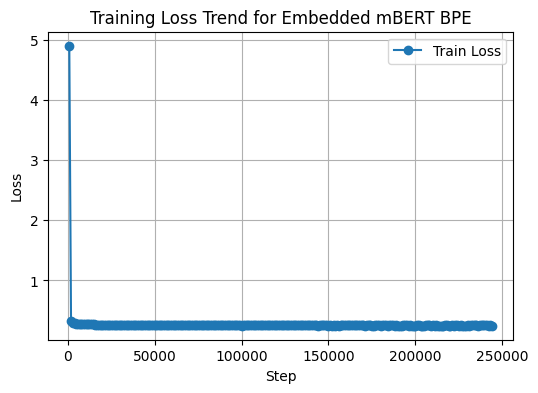

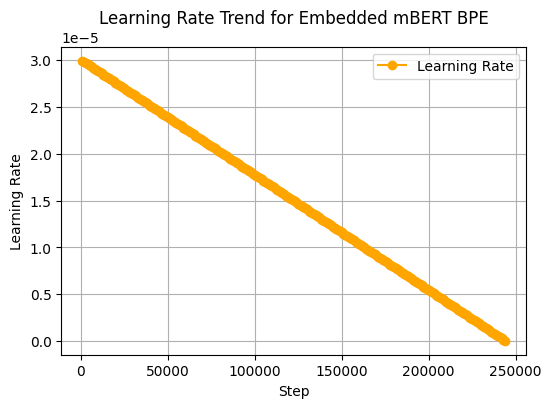

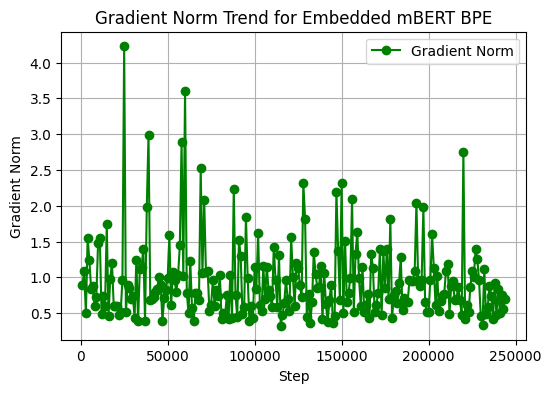

In [11]:
# plot train results
plot_training_metrics(mbert_bpe_embedded_fined_tuned_train_results, "Embedded mBERT BPE")

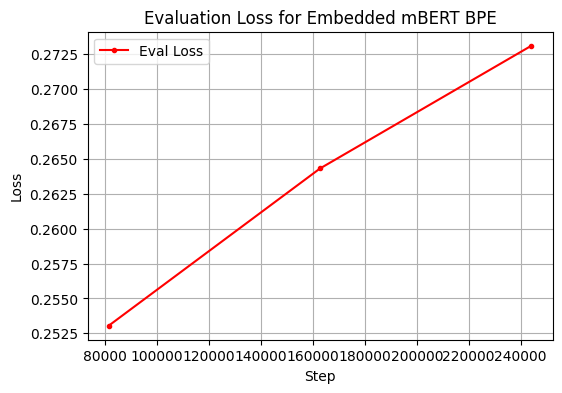

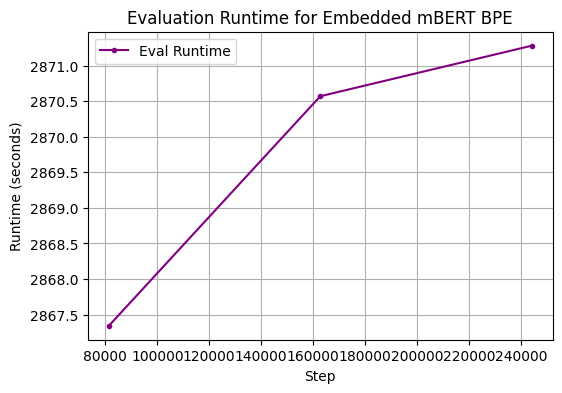

In [12]:
# plot eval results
plot_evaluation_metrics(mbert_bpe_embedded_fined_tuned_eval_results, "Embedded mBERT BPE")

In [13]:
# display final result
display(mbert_bpe_embedded_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
246,244137,0.0,0.27382,80060.179688,48.791,3.049


In [14]:
# save train results
save_model_variants_gen_df(mbert_bpe_embedded_fined_tuned_train_results, "mbert_bpe_embedded_fined_tuned_train_results")
save_model_variants_gen_df(mbert_bpe_embedded_fined_tuned_eval_results, "mbert_bpe_embedded_fined_tuned_eval_results")
save_model_variants_gen_df(mbert_bpe_embedded_fine_tuned_final_results, "mbert_bpe_embedded_fine_tuned_final_results")

#### Unigram

In [ ]:
# load train results
mbert_unigram_embedded_fined_tuned_train_results, mbert_unigram_embedded_fined_tuned_eval_results, mbert_unigram_embedded_fine_tuned_final_results = extract_metrics_from_logs("Embedded_mBERT_UNIGRAM")

In [ ]:
# plot train results
plot_training_metrics(mbert_unigram_embedded_fined_tuned_train_results, "mBERT Unigram")

In [ ]:
# plot eval results
plot_evaluation_metrics(mbert_unigram_embedded_fined_tuned_eval_results, "mBERT Unigram")

In [ ]:
# display final result
display(mbert_unigram_embedded_fine_tuned_final_results)

In [ ]:
# save train results
save_model_variants_gen_df(mbert_unigram_embedded_fined_tuned_train_results, "mbert_unigram_embedded_fined_tuned_train_results")
save_model_variants_gen_df(mbert_unigram_embedded_fined_tuned_eval_results, "mbert_unigram_embedded_fined_tuned_eval_results")
save_model_variants_gen_df(mbert_unigram_embedded_fine_tuned_final_results, "mbert_unigram_embedded_fine_tuned_final_results")

### XLM-R

#### BPE

In [9]:
# load train results
xlmr_bpe_embedded_fined_tuned_train_results, xlmr_bpe_embedded_fined_tuned_eval_results, xlmr_bpe_embedded_fine_tuned_final_results = extract_metrics_from_logs("Embedded_XLM-R_BPE")

Latest TensorFlow Event File: model-variants/logs/Embedded_XLM-R_BPE/events.out.tfevents.1740404505.ip-172-16-17-19.ap-northeast-1.compute.internal.24760.0


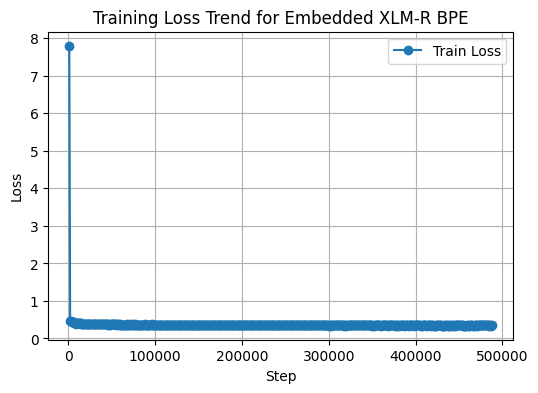

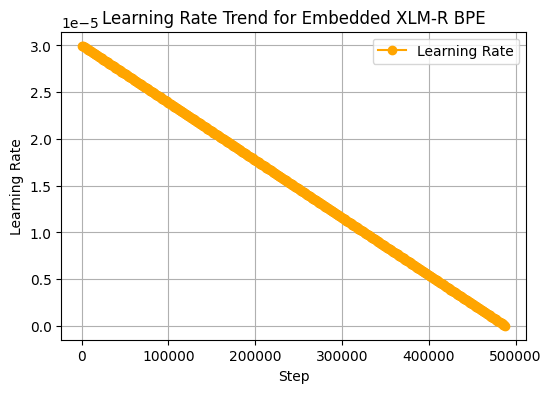

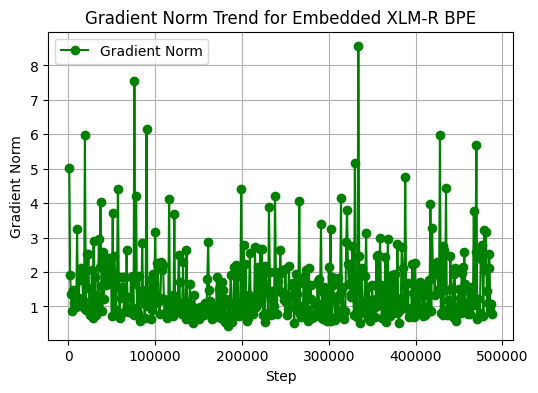

In [10]:
# plot train results
plot_training_metrics(xlmr_bpe_embedded_fined_tuned_train_results, "Embedded XLM-R BPE")

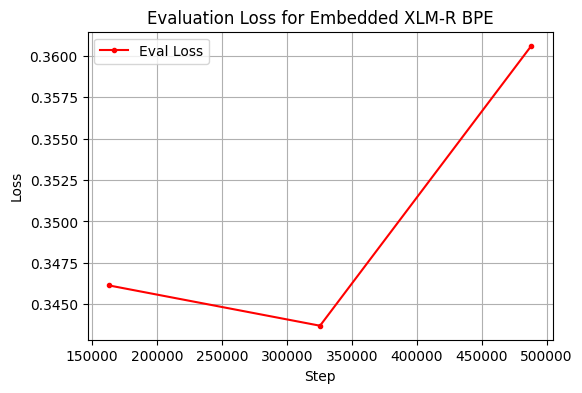

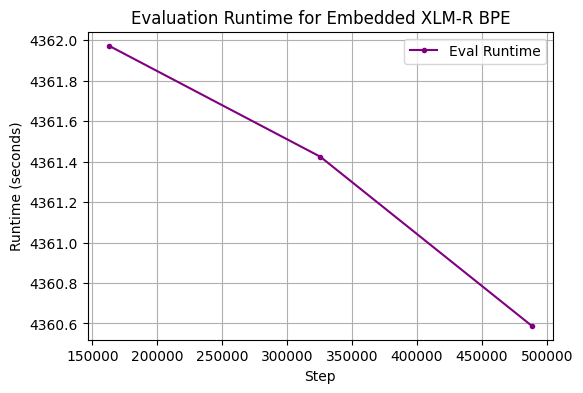

In [11]:
# plot eval resulxts
plot_evaluation_metrics(xlmr_bpe_embedded_fined_tuned_eval_results, "Embedded XLM-R BPE")

In [12]:
# display final result
display(xlmr_bpe_embedded_fine_tuned_final_results)

metric,step,final_total_flos,final_train_loss,final_train_runtime,final_train_samples_per_second,final_train_steps_per_second
490,488274,0.0,0.373927,119815.0625,32.602001,4.075


In [13]:
# save train results
save_model_variants_gen_df(xlmr_bpe_embedded_fined_tuned_train_results, "xlm-r_bpe_embedded_fined_tuned_train_results")
save_model_variants_gen_df(xlmr_bpe_embedded_fined_tuned_eval_results, "xlm-r_bpe_embedded_fined_tuned_eval_results")
save_model_variants_gen_df(xlmr_bpe_embedded_fine_tuned_final_results, "xlm-r_bpe_embedded_fine_tuned_final_results")

#### Unigram

In [ ]:
# load train results
xlmr_unigram_embedded_fined_tuned_train_results, xlmr_unigram_embedded_fined_tuned_eval_results, xlmr_unigram_embedded_fine_tuned_final_results = extract_metrics_from_logs("Embedded XLM-R_UNIGRAM")

In [ ]:
# plot train results
plot_training_metrics(xlmr_unigram_embedded_fined_tuned_train_results, "Embedded XLM-R Unigram")

In [ ]:
# plot eval results
plot_evaluation_metrics(xlmr_unigram_embedded_fined_tuned_eval_results, "Embedded XLM-R Unigram")

In [ ]:
# display final result
display(xlmr_unigram_embedded_fine_tuned_final_results)

In [ ]:
# save train results
save_model_variants_gen_df(xlmr_unigram_embedded_fined_tuned_train_results, "xlm-r_unigram_embedded_fined_tuned_train_results")
save_model_variants_gen_df(xlmr_unigram_embedded_fined_tuned_eval_results, "xlm-r_unigram_embedded_fined_tuned_eval_results")
save_model_variants_gen_df(xlmr_unigram_embedded_fine_tuned_final_results, "xlm-r_unigram_embedded_fine_tuned_final_results")

## Generate Predictions

In [ ]:
# Function to generate predictions for fine-tuned model using Hugging Face Dataset
def generate_predictions_embedded_fine_tuned_model(model_name, spt_name):
    base_model_name = train_model_names[model_name]

    # Load tokenizers & models
    model, tokenizer = get_embedded_fine_tuned_model(model_name, spt_name, base_model_name, device)
    model.eval()

    # Load dataset 
    dataset = load_models_df("multilingual_combined")

    dataset = convert_to_hf(dataset)

    # remove comment for debug
    # dataset = dataset.select(range(100))

    # Run text generation
    if "mt5" in model_name.lower():
        dataset = generate_mt5_predictions_hf_batch(dataset, model, tokenizer, device)
    else:
        dataset = generate_masked_predictions_hf_batch(dataset, model, tokenizer, device)

    # Display results
    display(dataset.to_pandas().head())

    # Save dataset
    save_model_variants_gen_df(dataset, f"{model_name.lower()}_{spt_name}_embedded_trained_predictions")

### mBERT

In [ ]:
# generate predictions for mbert with BPE
generate_predictions_embedded_fine_tuned_model("mBERT", "bpe")

In [ ]:
# generate predictions for mbert with Unigram
generate_predictions_embedded_fine_tuned_model("mBERT", "unigram")

### XLM-R

In [ ]:
# generate predictions for XLM-R with BPE
generate_predictions_embedded_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# generate predictions for XLM-R with Unigram
generate_predictions_embedded_fine_tuned_model("XLM-R", "unigram")

## Evaluate Model Performance
Compute BLEU, ROUGE-1, ROUGE-2, ROUGE-3, ROUGE-L, chrF-S, BERTScore and Perplexity scores.

### Metrics

In [ ]:
# Function to Compute Metrics for Fine-Tuned Model using HF Dataset
def compute_metric_embedded_fine_tuned_model(model_name, spt_name):
    # Load dataset
    metrics_dataset = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_embedded_trained_predictions")
    metrics_dataset = convert_to_hf(metrics_dataset)

    # if debug, remove comment
    #metrics_dataset = metrics_dataset.select(range(100))  # Keep this for debugging

    # Compute metrics
    print(f"Processing Data for {model_name} with {spt_name.upper()}...")
    metrics_dataset = compute_metrics_hf_batch(metrics_dataset, device)

    # Display results
    print(f"Metrics scores for {model_name} with {spt_name.upper()}:")
    print(f"BLEU Score: {np.mean(metrics_dataset['bleu'])}")
    print(f"ROUGE-1 Score: {np.mean(metrics_dataset['rouge-1'])}")
    print(f"ROUGE-2 Score: {np.mean(metrics_dataset['rouge-2'])}")
    print(f"ROUGE-L Score: {np.mean(metrics_dataset['rouge-l'])}")
    print(f"chrF-S Score: {np.mean(metrics_dataset['chrf-s'])}")
    print(f"BERT Score: {np.mean(metrics_dataset['bert_score'])}")

    # Save results
    save_tmp_df(metrics_dataset, f"{model_name.lower()}_{spt_name}_embedded_trained_metrics")

#### mBERT

In [ ]:
# compute metric for fine tuned mBERT with BPE
compute_metric_embedded_fine_tuned_model("mBERT", "bpe")

In [ ]:
# compute metric for fine tuned mBERT with Unigram
compute_metric_embedded_fine_tuned_model("mBERT", "unigram")

#### XLM-R

In [ ]:
# compute metric for fine tuned XLM-R with BPE
compute_metric_embedded_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# compute metric for fine tuned XLM-R with Unigram
compute_metric_embedded_fine_tuned_model("XLM-R", "unigram")

### Perplexity

In [ ]:
def compute_perplexity_embedded_fine_tuned_model(model_name, spt_name, batch_size=16):
    """
    Computes perplexity for a fine-tuned model using Hugging Face Dataset in batches.
    """
    base_model_name = train_model_names[model_name]

    print(f"Loading dataset for {model_name} with {spt_name}...")
    perplexity_dataset = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_embedded_trained_predictions")

    perplexity_dataset = convert_to_hf(perplexity_dataset)

    # for debug, remove comment
    #perplexity_dataset = perplexity_dataset.select(range(100))

    # Load Model & Tokenizer
    model, tokenizer = get_embedded_fine_tuned_model(model_name, spt_name, base_model_name, device)
    model.eval()

    print(f"Computing perplexity in batches of {batch_size}...")
    
    def compute_perplexity_batch(batch):
        texts = batch["generated"]  # Get text batch
        
        # Ensure all elements are strings and remove None values
        texts = [str(text) if text is not None else "" for text in texts]
        
        perplexity_scores = compute_multilingual_masked_perplexity_hf_batch(texts, model, tokenizer, device)

        return {"perplexity": perplexity_scores}

    # Compute perplexity in batches
    perplexity_dataset = perplexity_dataset.map(compute_perplexity_batch, batched=True, batch_size=batch_size)

    # Display Results
    mean_perplexity = np.mean(perplexity_dataset["perplexity"])
    print(f"Perplexity Score: {mean_perplexity:.4f}")

    # Save dataset
    save_tmp_df(perplexity_dataset, f"{model_name.lower()}_{spt_name}_embedded_trained_perplexity")

#### mBERT

In [ ]:
# compute perplexity with BPE
compute_perplexity_embedded_fine_tuned_model("mBERT", "bpe")

In [ ]:
# compute perplexity with Unigram
compute_perplexity_embedded_fine_tuned_model("mBERT", "unigram")

#### XLM-R

In [ ]:
# compute perplexity with BPE
compute_perplexity_embedded_fine_tuned_model("XLM-R", "bpe")

In [ ]:
# compute perplexity with Unigram
compute_perplexity_embedded_fine_tuned_model("XLM-R", "unigram")

### Save Evaluation Results

In [ ]:
# combine evaluation results
for model_name in train_model_names.keys():
    for spt_name in spt_models.keys():
        print(f"Processing {model_name} with {spt_name}...")

        evaluation_results = load_model_variants_gen_df(f"{model_name}_{spt_name}_trained_predictions")

        # load metrics and set
        metrics = load_tmp_df(f"{model_name}_{spt_name}_trained_metrics")
        evaluation_results["bleu"] = metrics["bleu"]
        evaluation_results["rouge-1"] = metrics["rouge-1"]
        evaluation_results["rouge-2"] = metrics["rouge-2"]
        evaluation_results["rouge-l"] = metrics["rouge-l"]
        evaluation_results["chrf-s"] = metrics["chrf-s"]
        evaluation_results["bert_score"] = metrics["bert_score"]

        # load perplexity and set
        perplexity = load_tmp_df(f"{model_name}_{spt_name}_trained_perplexity")
        evaluation_results["perplexity"] = perplexity["perplexity"]

        save_model_variants_gen_df(evaluation_results, f"{model_name.lower()}_{spt_name}_embedded_trained_evaluation_results")

## Benchmarking and Analysis
Compare the performance of LSTM BPE, LSTM Unigram, mBERT, and XLM-R using BLEU, ROUGE, chrF-S, BERT Score and Perplexity.

In [ ]:
# load data
embedded_trained_benchmarking_datasets = {}
for model_name in train_model_names.keys():
    for spt_name in spt_models.keys():
        df = load_model_variants_gen_df(f"{model_name.lower()}_{spt_name}_embedded_trained_evaluation_results")
        embedded_trained_benchmarking_datasets[f"{model_name} {spt_name.upper()}"] = df

In [ ]:
# convert to mean score df
embedded_trained_benchmarking_mean_scores = convert_to_mean_scores_df(embedded_trained_benchmarking_datasets)

In [ ]:
# Display mean scores
display(embedded_trained_benchmarking_mean_scores)

In [ ]:
# save benchmarking results
save_model_variants_gen_df(embedded_trained_benchmarking_mean_scores, "embedded_trained_evaluation_results")

# 3. Extract Contextual Embeddings

## Extract

In [7]:
def extract_contextual_embeddings(model_name, spt_name):
    """
    Extracts contextual embeddings and saves them in PyTorch (.pt) and NumPy (.npy) formats.
    """

    # ✅ Load tokenizer & model
    base_model_name = train_model_names[model_name]
    model, tokenizer = get_embedded_fine_tuned_model(model_name, spt_name, base_model_name, device)
    model.eval()

    # ✅ Load dataset (Ensure batch processing)
    dataset = load_models_df("multilingual_combined")  # Modify as needed
    dataset = convert_to_hf(dataset)  # Convert to Hugging Face Dataset if necessary

    # Uncomment for debugging with a smaller dataset
    # dataset = dataset.select(range(100))  

    def extract_embeddings(batch):
        """
        Tokenizes input text and extracts contextual embeddings.
        """
        device = next(model.parameters()).device  # Ensure consistency

        # ✅ Tokenize batch and move to GPU
        inputs = tokenizer(
            batch["burmese"],  # Modify key based on dataset
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to `cuda`

        # ✅ Extract embeddings
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # (batch_size, hidden_dim)

        return {"contextual_embeddings": cls_embeddings.cpu()}  # Keep as tensor

    # ✅ Efficient batch processing
    dataset = dataset.map(extract_embeddings, batched=True, batch_size=16)

    # ✅ Save embeddings
    file_name = f"{model_name.lower()}_{spt_name}_contextual_embeddings"

    # ✅ Fix: Convert to PyTorch tensor properly
    embeddings_list = dataset["contextual_embeddings"]

    if isinstance(embeddings_list[0], np.ndarray):
        embeddings_tensor = torch.tensor(np.array(embeddings_list))  # Convert NumPy array → Tensor
    elif isinstance(embeddings_list[0], list):
        embeddings_tensor = torch.tensor(np.array([np.array(e) for e in embeddings_list]))  # Convert list of lists → Tensor
    else:
        embeddings_tensor = torch.stack(embeddings_list)  # If already tensors, stack them directly

    # ✅ Save in PyTorch format
    torch.save(embeddings_tensor, f"model-variants/gen/{file_name}.pt")

    # ✅ Save in NumPy format
    np.save(f"model-variants/gen/{file_name}.npy", embeddings_tensor.numpy())

    print(f"✅ Contextual embeddings saved: {file_name}.pt & {file_name}.npy")

### mBERT

In [ ]:
# with bpe
extract_contextual_embeddings("mBERT", "bpe")

Map:   0%|          | 0/1627576 [00:00<?, ? examples/s]

In [ ]:
# with unigram
extract_contextual_embeddings("mBERT", "unigram")

### XLM-R

In [ ]:
# with bpe
extract_contextual_embeddings("XLM-R", "bpe")

In [ ]:
# with unigram
extract_contextual_embeddings("XLM-R", "unigram")

## Combine

In [10]:
# Define a projection layer (1536 → 768)
projection_layer = nn.Linear(1536, 768).to(device)

In [11]:
def combine_contextual_embeddings(spt_name):
    """
    Combines mBERT and XLM-R contextual embeddings, applies projection (1536 → 512 for mT5), 
    and saves in PyTorch & NumPy formats.
    """
    # ✅ Load extracted embeddings (Move to GPU after loading)
    mbert_embeddings = torch.load(f"model-variants/gen/mbert_{spt_name}_contextual_embeddings.pt").to(device)
    xlmr_embeddings = torch.load(f"model-variants/gen/xlm-r_{spt_name}_contextual_embeddings.pt").to(device)

    # ✅ Check embedding shapes
    assert mbert_embeddings.shape == xlmr_embeddings.shape, "Embedding dimensions mismatch!"
    
    print("mBERT Shape:", mbert_embeddings.shape)
    print("XLM-R Shape:", xlmr_embeddings.shape)

    # ✅ Concatenate embeddings (768 + 768 = 1536)
    combined_embeddings = torch.cat([mbert_embeddings, xlmr_embeddings], dim=1).to(device)

    # ✅ Convert to float32 to match projection layer dtype
    combined_embeddings = combined_embeddings.to(torch.float32)  

    print("Combined Embeddings Shape:", combined_embeddings.shape)  # (num_samples, 1536)

    # ✅ Fix for mT5: Use projection (1536 → 512)
    projection_layer = nn.Linear(1536, 512).to(device)  # mT5 uses 512D hidden size

    # ✅ Apply projection
    projected_embeddings = projection_layer(combined_embeddings)
    print("Projected Embeddings Shape:", projected_embeddings.shape)  # (num_samples, 512)

    # ✅ Save projected embeddings in PyTorch format
    torch.save(projected_embeddings, f"model-variants/gen/{spt_name}_mt5_projected_contextual_embeddings.pt")

    # ✅ Fix: Detach before converting to NumPy
    np.save(
        f"model-variants/gen/{spt_name}_mt5_projected_contextual_embeddings.npy",
        projected_embeddings.detach().cpu().numpy()  # ✅ Fix applied here
    )

    print(f"✅ Combined embeddings saved for `{spt_name}` in both .pt and .npy formats for mT5!")

In [ ]:
# combine for bpe
combine_contextual_embeddings("bpe")

In [ ]:
# combine for unigram
combine_contextual_embeddings("unigram")